# references:
https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/

In [2]:
# import required libraries
#!conda install nltk
import numpy as np
import pandas as pd
import nltk
import re
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mathilda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
with open('pride_and_prejudice.txt','r') as f:
#with open('Pride and Prejudice.txt','r') as f:
    full_txt = f.read().strip('\n').replace("\''","'")
    # clean the unnecessary txt
    full_txt = full_txt.replace('_','').replace('make by 拉米网（www.lami.fun）','') 

## Partition (chapters/paragraphs/sentences)

In [4]:
# chapter-wise
chapter_txt = full_txt.split('Chapter ')[1:] #len(chapter_txt)=61
cleaned_chapter = []
for chapter in chapter_txt:
    cleaned_chapter.append(chapter[1:].replace('\n',''))
len(cleaned_chapter)

61

In [5]:
# paragraph-wise
cleaned_paragraph = []
for chapter in chapter_txt:
    para = [i for i in chapter.split('\n') if i != ""]
    cleaned_paragraph = cleaned_paragraph + para[1:]
len(cleaned_paragraph)

2063

In [6]:
# sentence-wise
cleaned_sentence = []
from nltk.tokenize import sent_tokenize
cleaned_sentence = [sent_tokenize(chapter) for chapter in cleaned_chapter]
cleaned_sentence = [x for y in cleaned_sentence for x in y]
len(cleaned_sentence)

5584

In [7]:
from nltk.tokenize import sent_tokenize
total_sentences = [sent_tokenize(chapter) for chapter in cleaned_chapter]
#cleaned_sentence = [x for y in cleaned_sentence for x in y]
sentencesPerChap = [len(sentences) for sentences in total_sentences]
split_point = [0]
for i in range(len(total_sentences)):
    split_point.append(split_point[i]+sentencesPerChap[i])
split_point

[0,
 56,
 109,
 192,
 242,
 291,
 400,
 487,
 591,
 693,
 807,
 901,
 917,
 988,
 1035,
 1076,
 1228,
 1273,
 1476,
 1552,
 1641,
 1720,
 1776,
 1825,
 1926,
 1994,
 2104,
 2165,
 2221,
 2333,
 2358,
 2432,
 2490,
 2584,
 2677,
 2782,
 2843,
 2905,
 2946,
 3035,
 3142,
 3243,
 3300,
 3502,
 3559,
 3605,
 3747,
 3951,
 4038,
 4194,
 4268,
 4370,
 4534,
 4689,
 4774,
 4900,
 5086,
 5158,
 5290,
 5462,
 5550,
 5584]

In [8]:
CHARACTER_LIST = [
    'Darcy', 'Bingley','Elizabeth','Caroline','Lydia','Catherine','Georgianna','Collins','Charlotte','Wickham','Miss de Bourgh','Colonel','Mr. Bennet','Mrs. Bennet'
]

NICKNAME_LIST = [
    'Lizzy','Kitty','Miss Lucas','Miss Bingley','Miss Darcy'
]

MATCH = [(2,0),(3,1),(8,2),(3,3),(6,4)]



num_people = len(CHARACTER_LIST)

In [9]:
def name_plus_nick(list_1,list_2):
    co_list = []
    len_1 = len(list_1)
    for i in range(len_1):
        if list_1[i]+list_2[i] == 0:
            co_list.append(0)
        else:
            co_list.append(1)
    return co_list

In [10]:
def find_interaction(sections):
    Characters = {}
    occurrence = []
    occurrence_2 = []
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence.append(np.array(vector))
        Characters[person] = np.array(vector)
    
    for person in CHARACTER_LIST:
        vector = []
        for section in sections:
            if person in section:
                vector.append(1)
            else:
                vector.append(0)
        occurrence_2.append(np.array(vector))
    
    for match in MATCH:
        name = match[0]
        nick = match[1]
        occur_new = name_plus_nick(occurrence[name],occurrence_2[nick])
        occurrence[name] = occur_new
        person = CHARACTER_LIST[name]
        Characters[person] = occur_new

    occurrence_matrix = pd.DataFrame(occurrence) # num of people * num of sections 15*61
    co_occur = pd.DataFrame(np.dot(occurrence_matrix,occurrence_matrix.T))
    co_occur = co_occur / np.linalg.norm(co_occur, ord = 1, axis = 0)
    return co_occur, occurrence_matrix, Characters

In [11]:
def text_rank(section_name, section):
    co_occur, occurrence, Characters = find_interaction(section)
    #print(co_occur)
    P = co_occur
    alpha = 0.85
    P = alpha* co_occur + (1-alpha)*np.ones((num_people,num_people))/num_people
    
    # interation PageRank
    rank_inter = np.ones((num_people, 1))/num_people
    for i in range(100000):
        rank_inter = np.dot(P,rank_inter)
    rank_inter = rank_inter.reshape(-1,)
    
    text_rank = rank_inter[np.argsort(rank_inter)[::-1]].tolist()
    text_chara = [CHARACTER_LIST[i] for i in np.argsort(rank_inter)[::-1].tolist()]
    Characters_sort = sorted(Characters.items(), key=lambda x: sum(x[1]), reverse = True)
    occur_rank = [sum(character[1]) for character in Characters_sort]
    occur_chara = [character[0] for character in Characters_sort]
  
    rank_table = pd.DataFrame([text_chara, occur_chara]).T
    rank_table.columns = ['TextRank','Occurrence Rank']
    rank_table.index = np.arange(1,num_people+1).tolist()
    print(rank_table)
    
    x = np.arange(len(CHARACTER_LIST)).tolist()
    plt.bar(x, text_rank)
    plt.xticks(x, text_chara, rotation=50)
    plt.title(f'PageRank by {section_name} (Descending)')

    plt.show()
    return occurrence

          TextRank Occurrence Rank
1        Charlotte       Elizabeth
2        Elizabeth       Charlotte
3            Darcy           Darcy
4         Caroline         Bingley
5          Bingley        Caroline
6      Mrs. Bennet     Mrs. Bennet
7       Georgianna         Wickham
8            Lydia           Lydia
9          Wickham      Georgianna
10         Collins         Collins
11       Catherine       Catherine
12      Mr. Bennet      Mr. Bennet
13         Colonel         Colonel
14  Miss de Bourgh  Miss de Bourgh


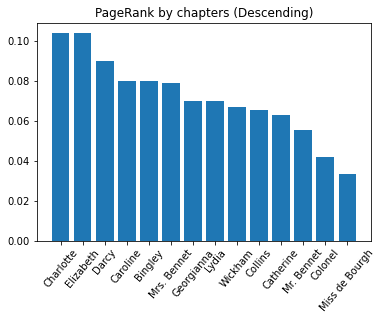

In [12]:
occur_chapter = text_rank('chapters', cleaned_chapter)

          TextRank Occurrence Rank
1        Elizabeth       Elizabeth
2        Charlotte       Charlotte
3            Darcy           Darcy
4         Caroline        Caroline
5          Bingley         Bingley
6       Georgianna         Wickham
7            Lydia         Collins
8          Collins           Lydia
9          Wickham      Georgianna
10     Mrs. Bennet     Mrs. Bennet
11       Catherine       Catherine
12      Mr. Bennet      Mr. Bennet
13         Colonel         Colonel
14  Miss de Bourgh  Miss de Bourgh


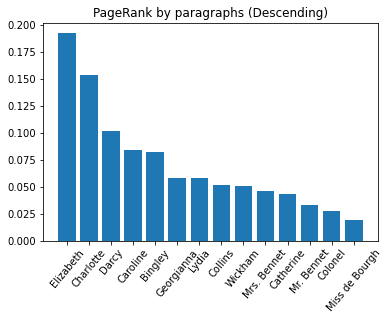

In [13]:
occur_paragraph = text_rank('paragraphs', cleaned_paragraph)

          TextRank Occurrence Rank
1        Elizabeth       Elizabeth
2        Charlotte       Charlotte
3            Darcy           Darcy
4         Caroline        Caroline
5          Bingley         Bingley
6       Georgianna         Wickham
7            Lydia         Collins
8          Collins           Lydia
9          Wickham      Georgianna
10       Catherine     Mrs. Bennet
11     Mrs. Bennet       Catherine
12      Mr. Bennet      Mr. Bennet
13         Colonel         Colonel
14  Miss de Bourgh  Miss de Bourgh


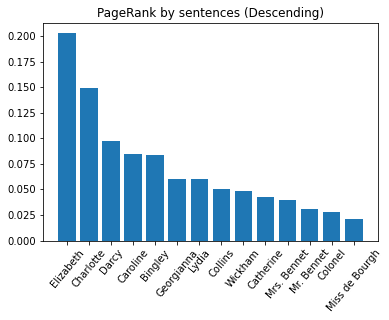

In [14]:
occur_sentence = text_rank('sentences', cleaned_sentence)

In [15]:
occur_sentence.index = CHARACTER_LIST
occur_sentence # character * sentences

,0,1,2,3,4,5,6,7,8,9,...,5574,5575,5576,5577,5578,5579,5580,5581,5582,5583
Darcy,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
Bingley,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Elizabeth,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1
Caroline,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Lydia,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Catherine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Georgianna,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Collins,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Charlotte,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,1,1
Wickham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sentiment Analysis
http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [16]:
#!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm_notebook as tqdm

In [33]:
analyzer = SentimentIntensityAnalyzer()
chaper_wise_sentiment = []
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
    sentiments['compound'] = sentiments['compound'] / len(sentence_list)
    sentiments['neg'] = sentiments['neg'] / len(sentence_list)
    sentiments['neu'] = sentiments['neu'] / len(sentence_list)
    sentiments['pos'] = sentiments['pos'] / len(sentence_list)
    chaper_wise_sentiment.append(sentiments)

<ipython-input-33-3b7698cd9e7d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chapter in tqdm(cleaned_chapter):


In [34]:
SENTIMENTS = ['compound', 'neg', 'neu', 'pos']
y = [[sentiments['compound'] for sentiments in chaper_wise_sentiment],
     [sentiments['neg'] for sentiments in chaper_wise_sentiment],
     [sentiments['neu'] for sentiments in chaper_wise_sentiment],
     [sentiments['pos'] for sentiments in chaper_wise_sentiment]
    ]

In [35]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

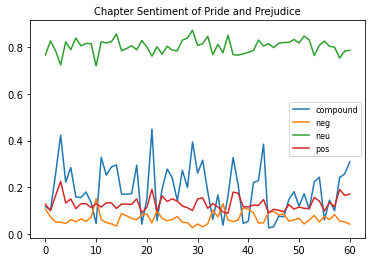

In [36]:
for i in range(len(SENTIMENTS)):
    plt.plot(y[i],label=SENTIMENTS[i])
    plt.legend(loc='best', fontsize=8)
    #plt.plot(movingaverage(y[i], 4), color='k', linewidth=1, linestyle=':', label = 'Moving Average')
plt.title('Chapter Sentiment of Pride and Prejudice', fontsize=10)
plt.show()

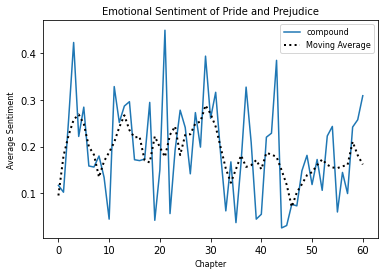

In [37]:
plt.plot(y[0],label=SENTIMENTS[0])
plt.plot(movingaverage(y[0], 5), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=8)
plt.title('Emotional Sentiment of Pride and Prejudice', fontsize=10)
plt.xlabel('Chapter', fontsize=8)
plt.ylabel('Average Sentiment', fontsize=8)
plt.show()

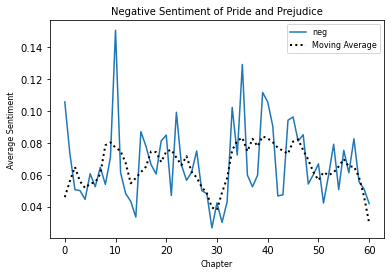

In [38]:
plt.plot(y[1],label=SENTIMENTS[1])
plt.plot(movingaverage(y[1], 5), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=8)
plt.title('Negative Sentiment of Pride and Prejudice', fontsize=10)
plt.xlabel('Chapter', fontsize=8)
plt.ylabel('Average Sentiment', fontsize=8)
plt.show()

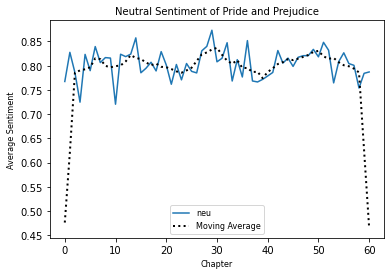

In [39]:
plt.plot(y[2],label=SENTIMENTS[2])
plt.plot(movingaverage(y[2], 5), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=8)
plt.title('Neutral Sentiment of Pride and Prejudice', fontsize=10)
plt.xlabel('Chapter', fontsize=8)
plt.ylabel('Average Sentiment', fontsize=8)
plt.show()

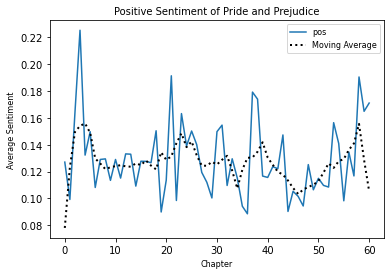

In [41]:
plt.plot(y[3],label=SENTIMENTS[3])
plt.plot(movingaverage(y[3], 5), color='k', linewidth=2, linestyle=':', label = 'Moving Average')
plt.legend(loc='best', fontsize=8)
plt.title('Positive Sentiment of Pride and Prejudice', fontsize=10)
plt.xlabel('Chapter', fontsize=8)
plt.ylabel('Average Sentiment', fontsize=8)
plt.show()

---

In [87]:
analyzer_2 = SentimentIntensityAnalyzer()
sentiments = {'compound': [], 'neg': [], 'neu': [], 'pos': []}
for chapter in tqdm(cleaned_chapter):
    sentence_list = nltk.tokenize.sent_tokenize(chapter)
    for sentence in sentence_list:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'].append(vs['compound'])
        sentiments['neg'].append(vs['neg'])
        sentiments['neu'].append(vs['neu'])
        sentiments['pos'].append(vs['pos'])

<ipython-input-87-5c5fac2c0179>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chapter in tqdm(cleaned_chapter):


In [92]:
sentiment_matrix = pd.DataFrame(sentiments).T # sentiment * sentences
np.shape(sentiment_matrix)

(4, 5584)

In [49]:
#!pip install afinn
from afinn import Afinn
afinn = Afinn()
sentiment_scores = np.matrix([afinn.score(sentence) for sentence in cleaned_sentence]).T

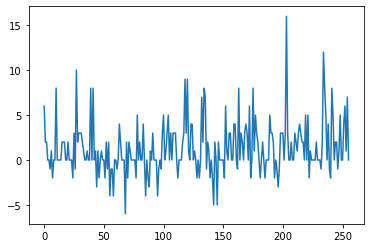

In [93]:
plt.plot(sentiment_scores[0:sum(sentencesPerChap[:4])])

In [55]:
np.shape(sentiment_scores)

(5976, 1)

In [53]:
np.shape(occur_sentence.T)

(5976, 14)

In [75]:
np.linspace(-2, 2, 5)

array([-2., -1.,  0.,  1.,  2.])

----


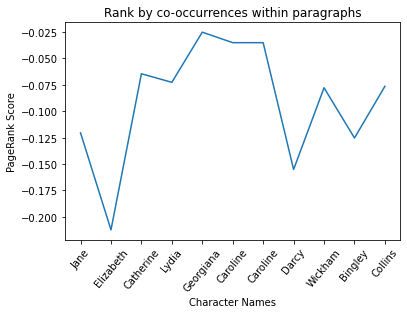

In [138]:
# Eigenvalue method
w,v = np.linalg.eig(P) #这里为啥用P就不对呢…… 奇了怪了 -P是对的？
x = np.arange(len(CHARACTER_LIST))
rank_eigen = v[:,0]/np.linalg.norm(v[:,0], ord = 1) 
plt.plot(x,rank_eigen)
plt.xticks(x, CHARACTER_LIST, rotation=50)
plt.xlabel('Character Names')
plt.ylabel('PageRank Score')
plt.title(f'Rank by co-occurrences within {section_name}')
plt.show()

## Named entity recognition (NER)
is probably the first step towards information extraction that seeks to locate and classify named entities in text into pre-defined categories such as the names of persons,

In [ ]:
from __future__ import print_function
import nltk
print(nltk.__version__)

## Gephi 可视化


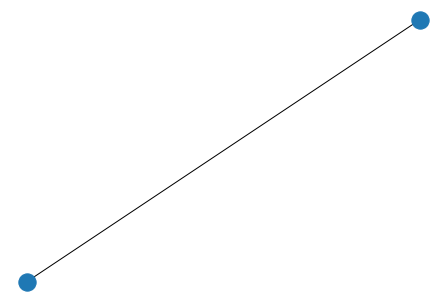

[1, 2]

In [11]:
import networkx as nx
G = nx.Graph() # 创建空图

G.add_node(1, time='5pm') # 添加节点，并赋节点属性
G.add_edge(1, 2, weight=4.7 ) # 添加边，并赋边属性

# 图显示需要借助matplotlib
import matplotlib.pyplot as plt

nx.draw(G) #绘制网络G
plt.show() # 在窗口中显示这幅图像
nx.write_gexf(G,'your_file_name.gexf') # 将图存为gexf文件，进而使用Gephi可视化


G._node # 节点及其属性的字典
G._adj # 节点及其邻居节点的字典
list(G.nodes()) # 节点列表

# 查找某一节点的邻居节点